In [12]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/application-to-ml-project/data_insurance.csv


In [13]:
df = pd.read_csv("/kaggle/input/application-to-ml-project/data_insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [15]:
# Checking for missing values
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [16]:
df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


## Exploratory Data Analysis

/usr/local/lib/python3.11/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


<Axes: xlabel='charges', ylabel='Count'>

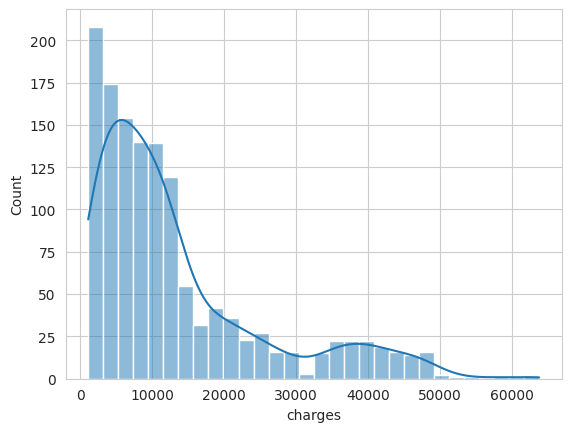

In [17]:
sns.histplot(data=df, x='charges', kde=True)

<Axes: xlabel='charges'>

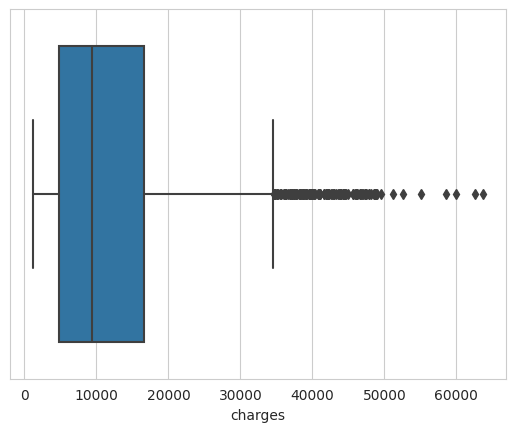

In [18]:
sns.boxplot(data=df, x='charges')

In [19]:
# Outlier detection and removal
# Q1 = df['charges'].quantile(0.25)
# Q3 = df['charges'].quantile(0.75)

# IQR = Q3 - Q1
# upper_fence = Q3 + 1.5*IQR
# lower_fence = Q1 - 1.5*IQR

# df = df[(df['charges'] >= lower_fence) & (df['charges'] <= upper_fence)]

In [20]:
X = df.drop(columns=["charges"])
y = df['charges']

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

numerical_features = ['age', 'bmi', 'children']
categorical_features = ['sex', 'smoker', 'region']

preprocessor = ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ], remainder='passthrough')

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('model', LinearRegression())
])

pipeline.fit(X_train, y_train)

y_train_pred = pipeline.predict(X_train)
y_test_pred = pipeline.predict(X_test)

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
train_mse = mean_squared_error(y_train, y_train_pred)
test_mse = mean_squared_error(y_test, y_test_pred)
train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print("\n" + "="*50)
print("MODEL EVALUATION RESULTS")
print("="*50)
print(f"Training R² Score: {train_r2:.4f}")
print(f"Test R² Score: {test_r2:.4f}")
print(f"Training MSE: {train_mse:,.2f}")
print(f"Test MSE: {test_mse:,.2f}")
print(f"Training RMSE: {train_rmse:,.2f}")
print(f"Test RMSE: {test_rmse:,.2f}")


MODEL EVALUATION RESULTS
Training R² Score: 0.7450
Test R² Score: 0.7673
Training MSE: 37,004,502.18
Test MSE: 35,117,755.74
Training RMSE: 6,083.13
Test RMSE: 5,926.02


In [22]:
feature_names = (numerical_features + 
                list(pipeline.named_steps['preprocessor']
                    .named_transformers_['cat']
                    .get_feature_names_out()))

coefficients = pipeline.named_steps['model'].coef_
feature_importance = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefficients,
    'abs_coefficient': np.abs(coefficients)
}).sort_values('abs_coefficient', ascending=False)

print(feature_importance)

            feature   coefficient  abs_coefficient
1               bmi  23630.398990     23630.398990
5  region_northwest   3643.065982      3643.065982
6  region_southeast   2042.265036      2042.265036
4        smoker_yes   -860.266712       860.266712
3          sex_male   -781.368389       781.368389
7  region_southwest    513.516894       513.516894
2          children   -355.148621       355.148621
0               age     45.622427        45.622427
